In [28]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
temp=pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [6]:
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [16]:

#Covert date column to datetime
temp['Date']=temp['dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   dt                             577462 non-null  object        
 1   AverageTemperature             544811 non-null  float64       
 2   AverageTemperatureUncertainty  545550 non-null  float64       
 3   Country                        577462 non-null  object        
 4   Date                           577462 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 22.0+ MB


In [20]:
#drop Na's
temp.dropna(inplace=True)
temp.drop(columns='dt', inplace=True)
temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,Date
0,4.384,2.294,Åland,1743-11-01
5,1.530,4.680,Åland,1744-04-01
6,6.702,1.789,Åland,1744-05-01
7,11.609,1.577,Åland,1744-06-01
8,15.342,1.410,Åland,1744-07-01


In [22]:
#1900 to date
temp=temp[temp['Date']>='1900-01-01']
temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,Date
1874,-3.026,0.538,Åland,1900-01-01
1875,-8.063,0.657,Åland,1900-02-01
1876,-3.196,0.467,Åland,1900-03-01
1877,0.781,0.224,Åland,1900-04-01
1878,4.960,0.503,Åland,1900-05-01


In [31]:
#Calculate average temp for each country
country_temps=temp.groupby('Country')['AverageTemperature'].mean()
country_temps
print(country_temps.nlargest(10))
print(country_temps.nsmallest(10))

<class 'pandas.core.series.Series'>
Index: 242 entries, Afghanistan to Åland
Series name: AverageTemperature
Non-Null Count  Dtype  
--------------  -----  
242 non-null    float64
dtypes: float64(1)
memory usage: 3.8+ KB


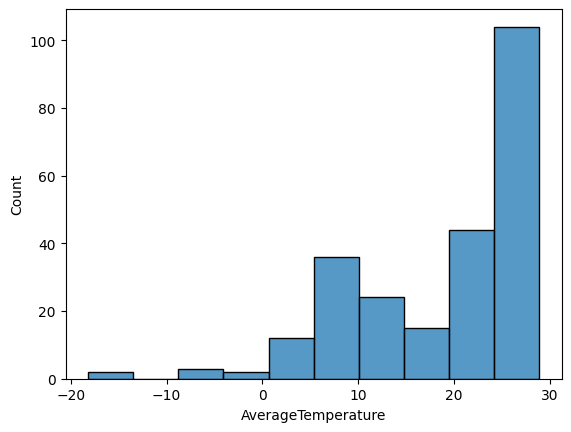

In [34]:
sns.histplot(data=country_temps)
plt.show()

In [77]:
country_temps[country_temps<=5]

Country
Canada                                       -4.743584
Denmark                                     -17.654628
Finland                                       1.668611
French Southern And Antarctic Lands           4.983111
Greenland                                   -18.185688
Heard Island And Mcdonald Islands             2.562115
Iceland                                       1.776205
Kyrgyzstan                                    3.489759
Liechtenstein                                 4.936000
Mongolia                                     -0.514383
North America                                 2.446777
Norway                                        0.468084
Russia                                       -5.167612
Saint Pierre And Miquelon                     4.705910
South Georgia And The South Sandwich Isla     1.433921
Svalbard And Jan Mayen                       -7.074860
Sweden                                        2.762112
Tajikistan                                    4.269776
Na

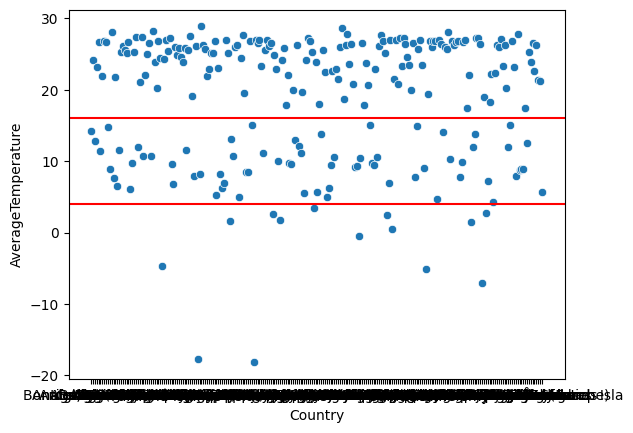

In [66]:
#Scatterplot with potential climate category lines
sns.scatterplot(data=country_temps)
plt.axhline(y = 16, color = 'r', linestyle = '-')
plt.axhline(y = 4, color = 'r', linestyle = '-')
plt.show()

Will need to remove Continents
Some European countries have multiple entries. Maybe european and colonial areas?

In [48]:
country_temps[country_temps.index.isin(['North America', 'South America', 'Africa', 'Europe', 'Asia','Antarctica', 'Åland', 'France', 'France (Europe)'])]
temp[temp['Country'].isin(['France','France (Europe)'])].sort_values(by=['Date'])

,AverageTemperature,AverageTemperatureUncertainty,Country,Date
182988,3.709,0.463,France (Europe),1900-01-01
186227,7.235,0.595,France,1900-01-01
186228,8.461,0.678,France,1900-02-01
182989,5.165,0.602,France (Europe),1900-02-01
182990,3.771,0.384,France (Europe),1900-03-01
...,...,...,...,...
184349,16.328,0.287,France (Europe),2013-06-01
187589,21.817,0.348,France,2013-07-01
184350,21.291,0.376,France (Europe),2013-07-01
184351,19.471,0.374,France (Europe),2013-08-01


Create a potential categorical bin of climates

In [67]:
climate=pd.DataFrame(country_temps)
climate['Climate']=pd.cut(country_temps,[-200,4,16,300],labels=['Cold','Moderate','Hot'])

In [68]:
climate

,AverageTemperature,Climate
Country,,
Afghanistan,14.225853,Moderate
Africa,24.242265,Hot
Albania,12.885981,Moderate
Algeria,23.266212,Hot
American Samoa,26.719510,Hot
...,...,...
Western Sahara,22.583814,Hot
Yemen,26.329659,Hot
Zambia,21.399847,Hot
